#### Imports

In [1]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
import time
from transformers import DistilBertTokenizer, DistilBertModel
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from hyperopt import hp
from scipy.stats import kruskal
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))


GPU Available: False
Number of GPU Available: 0


In [34]:
models_dir = "c:/transformer_models/"
if os.path.isdir(models_dir) is not True:
    os.mkdir(models_dir)

## Load the dataset

### IMDB dataset

In [3]:
imdb = load_dataset("imdb")

Found cached dataset imdb (C:/Users/rgolan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# embed the sentences - take 500 negative samples and 500 positive samples. Note that in the IMDB set, the negative examples are in the first half of the dataset (0-12500)
# the positive examples are in the second half
num_sentences_to_embed = 1000
neg_examples_idx = list(np.random.randint(low=0,high=12500,size=num_sentences_to_embed//2))
pos_examples_idx = list(np.random.randint(low=12500,high=25000,size=num_sentences_to_embed//2))
examples_to_embed_idx = neg_examples_idx + pos_examples_idx

In [5]:
train_sentences = [imdb['train'][int(i)]['text'] for i in examples_to_embed_idx]
train_labels = [imdb['train'][int(i)]['label'] for i in examples_to_embed_idx]
print(f"there are {len(train_sentences)} sentences in the training set")

there are 1000 sentences in the training set


## Get embeddings

#### BERT embeddings

In [13]:
# initialize a tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [14]:
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
embed_dim = bert_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")
bert_model.config.output_hidden_states

embedding dimension = 768


False

In [16]:
bert_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = bert_tokenizer(train_sentences[i], padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        output = bert_model(**input, output_hidden_states=True)
    # as the sentence embedding we're taking the hidden state corresponding to the [CLS] token
    bert_embeddings[i,:] = output.last_hidden_state[:,0,:].numpy()
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


processed 101 sentences
so far, 45.7897 seconds passed 


processed 201 sentences
so far, 89.3573 seconds passed 


processed 301 sentences
so far, 135.1618 seconds passed 


processed 401 sentences
so far, 183.8605 seconds passed 


processed 501 sentences
so far, 230.6930 seconds passed 


processed 601 sentences
so far, 274.4580 seconds passed 


processed 701 sentences
so far, 319.8834 seconds passed 


processed 801 sentences
so far, 362.6773 seconds passed 


processed 901 sentences
so far, 408.3203 seconds passed 




In [17]:
print(f"bert embeddings shape = {bert_embeddings.shape}")

bert embeddings shape = (1000, 768)


#### GPT2 embeddings

In [59]:
from transformers import AutoTokenizer, GPT2Model
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2", cache_dir=models_dir)
gpt2_model = GPT2Model.from_pretrained("gpt2", cache_dir=models_dir)

In [60]:
embed_dim = gpt2_model.config.n_embd
print(f"embedding dimension = {embed_dim}")
gpt2_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = gpt2_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = gpt2_model(**input)
    # with GPT2 embeddings, we take the mean of the hidden states of all tokens
    gpt2_embeddings[i,:] = output.last_hidden_state[:,:,:].numpy().mean(axis=1)
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


embedding dimension = 768
processed 101 sentences
so far, 42.8582 seconds passed 


processed 201 sentences
so far, 91.6387 seconds passed 


processed 301 sentences
so far, 144.5270 seconds passed 


processed 401 sentences
so far, 197.1737 seconds passed 


processed 501 sentences
so far, 239.5497 seconds passed 


processed 601 sentences
so far, 280.6733 seconds passed 


processed 701 sentences
so far, 336.2474 seconds passed 


processed 801 sentences
so far, 385.9106 seconds passed 


processed 901 sentences
so far, 437.8520 seconds passed 




#### XLNet embeddings

In [35]:
from transformers import XLNetModel

xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
xlnet_model = XLNetModel.from_pretrained("xlnet-base-cased", cache_dir=models_dir)

C:\python_venv\transfer_learning_with_feature_selection_python_3_10\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rgolan\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\python_venv\transfer_learning_with_feature_selection_python_3_10\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\transformer_models. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
embed_dim = xlnet_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")

embedding dimension = 768


In [47]:
xlnet_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = xlnet_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = xlnet_model(**input)
    xlnet_embeddings[i,:] = output.last_hidden_state[:,-1,:].numpy()
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")

processed 101 sentences
so far, 48.9625 seconds passed 


processed 201 sentences
so far, 103.2901 seconds passed 


processed 301 sentences
so far, 166.6987 seconds passed 


processed 401 sentences
so far, 224.0038 seconds passed 


processed 501 sentences
so far, 283.0298 seconds passed 


processed 601 sentences
so far, 338.2236 seconds passed 


processed 701 sentences
so far, 391.2476 seconds passed 


processed 801 sentences
so far, 439.1390 seconds passed 


processed 901 sentences
so far, 495.7874 seconds passed 




#### BART embeddings

In [25]:
from transformers import AutoTokenizer, BartModel

bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
bart_model = BartModel.from_pretrained("facebook/bart-base")
embed_dim = bart_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")

embedding dimension = 768


In [26]:
bart_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = bart_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = bart_model(**input)
    bart_embeddings[i,:] = output.last_hidden_state[:,:,:].numpy().mean(axis=1)
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


processed 101 sentences
so far, 39.4512 seconds passed 


processed 201 sentences
so far, 78.4378 seconds passed 


processed 301 sentences
so far, 123.5349 seconds passed 


processed 401 sentences
so far, 171.9170 seconds passed 


processed 501 sentences
so far, 212.9310 seconds passed 


processed 601 sentences
so far, 251.1884 seconds passed 


processed 701 sentences
so far, 301.0772 seconds passed 


processed 801 sentences
so far, 346.4800 seconds passed 


processed 901 sentences
so far, 392.7172 seconds passed 




## Classification of embedded test

In [61]:
embed_list = [gpt2_embeddings]
X = np.concatenate(embed_list,axis=1)
print(f"X shape = {X.shape}")

X shape = (1000, 768)


In [62]:
y = np.array(train_labels)

In [63]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}

hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X, y_train=y, iterations=50)
best_params = hyper_opt.run()
print(f"best_params = {best_params}")

100%|██████████| 50/50 [00:51<00:00,  1.02s/trial, best loss: -0.842]             
best_params = {'C': 0.19197108191310136, 'degree': 1, 'kernel': 'linear'}


Measuring accuracy with 2 classes,  5 training examples per class
---------------------------------------------------------------
In classifier with feature selector FeatureSelectionDiversityPursuitAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSelectionOneVsAllAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSelectionDiversityPursuitAnova no features were selected and classifier will not be fitted to data - will predict at random!
In classifier with feature selector FeatureSelectionOneVsAllAnova no features were selected and classifier will not be fitted to data - will predict at random!
classifier cs_cls, mean accuracy is 0.5, std accuracy is 0.0
classifier cs_fs_dp, mean accuracy is 0.5913131313131313, std accuracy is 0.0631095720139804
classifier cs_fs_ova, mean accuracy is 0.5904040404040404, s

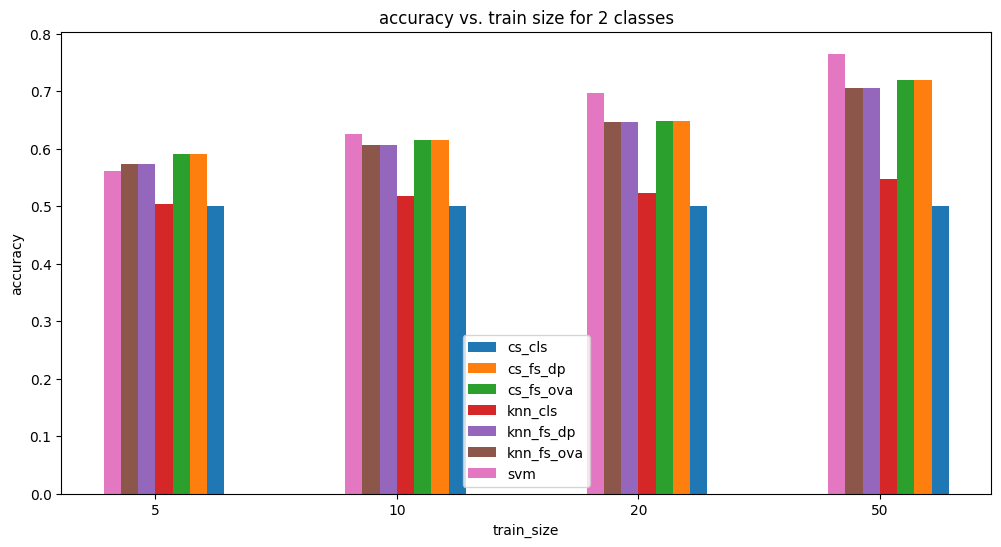

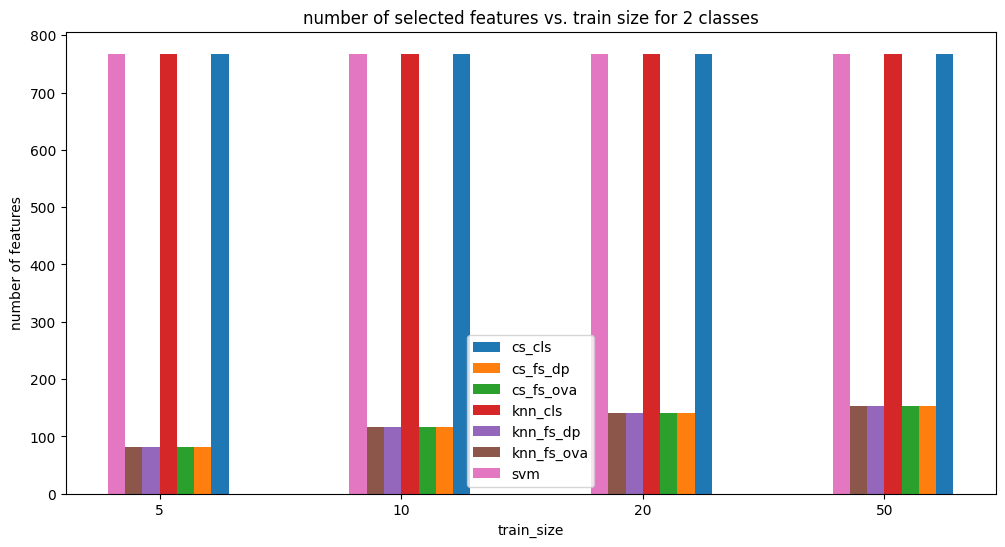

In [64]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova
gamma = 0.2
train_sizes = [5,10,20,50]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
num_experiments = 50
num_splits = 5
# define possible sizes for the train set (number of train examples per class)
num_classes = 2
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    print(f"Measuring accuracy with {num_classes} classes,  {train_sizes[i]} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_sizes[i]*num_classes, stratify=y)
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers,
                                                                                              X_train=X_train,
                                                                                              y_train=y_train,
                                                                                              X_test=X_test,
                                                                                              y_test=y_test)
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies[l,i,:])}, std accuracy is {np.std(accuracies[l,i,:])}")
    print("\n\n\n")

bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')